In [ ]:
!pip install tensorflow==2.3

In [2]:
!pip install retry

Using https://www.kaggle.com/cyannani123/keras-cellular-image-classification as test example

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB1
from tensorflow.python.client import device_lib
import tensorflow.keras as keras
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.utils import Sequence
import os, sys, random,copy
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFilter
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
sys.path.append('../scripts')

In [4]:
from data_new import augment
from data_new import get_center_box
from data_new import get_random_subbox
from data_new import ImgGen

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Loading test and train data.

Will load directly from zip for now.

In [6]:
test_data = pd.read_csv("../input/recbio/test.csv")
print("Shape of test_data:", test_data.shape)
test_data.head()

Shape of test_data: (19899, 4)


,id_code,experiment,plate,well
0,HEPG2-08_1_B03,HEPG2-08,1,B03
1,HEPG2-08_1_B04,HEPG2-08,1,B04
2,HEPG2-08_1_B05,HEPG2-08,1,B05
3,HEPG2-08_1_B06,HEPG2-08,1,B06
4,HEPG2-08_1_B07,HEPG2-08,1,B07


In [7]:
train_data = pd.read_csv("../input/recbio/train.csv")
print("Shape of test_data:", test_data.shape)
train_data.head()

Shape of test_data: (19899, 4)


,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,sirna_250
1,HEPG2-01_1_B04,HEPG2-01,1,B04,sirna_62
2,HEPG2-01_1_B05,HEPG2-01,1,B05,sirna_1115
3,HEPG2-01_1_B06,HEPG2-01,1,B06,sirna_602
4,HEPG2-01_1_B07,HEPG2-01,1,B07,sirna_529


In [8]:
sirna_label_encoder = LabelEncoder().fit(train_data.sirna)

Saidid on samast wellist tehtud eri pildid. Pm võib võtta ainult ühe saidi sisse.
Channelid on eri kanalitega tehtud pildid. Neid on kokku 6.

Kirjutan piltide laadimise klassi notebooki näitel

In [9]:
train_data = train_data.sample(frac=0.1).reset_index(drop=True)

In [10]:
train = ImgGen(train_data, preprocess=get_center_box, label_encoder=sirna_label_encoder, path='../input/recbio')

In [11]:
len(train)

114

In [12]:
from tqdm import tqdm

In [13]:
for i in tqdm(train):
    pass

100%|██████████| 114/114 [08:26<00:00,  4.44s/it]


In [14]:
first_batch=train[0]

In [18]:
first_batch[0].shape

(32, 6, 224, 224)

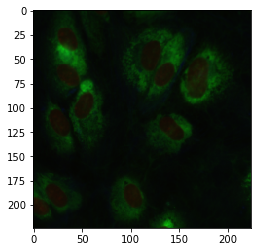

In [15]:
first_image_channels_1_3 = first_batch[0][0][0:3].transpose((1,2,0))
plt.imshow(first_image_channels_1_3, interpolation='nearest')

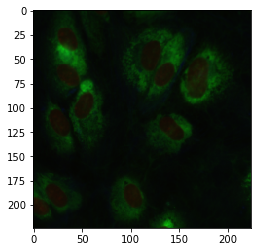

In [16]:
first_image_channels_4_6 = first_batch[0][0][3:6].transpose((1,2,0))
plt.imshow(first_image_channels_4_6, interpolation='nearest')

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate, Convolution2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

In [34]:
def create_cnn_model(learning_rate=0.001):
    """
    CNN model
    """

    input_data = Input(name="input_image",shape=(6,224,224))

    cnn_seq = Sequential([
        Convolution2D(filters=64, kernel_size=(3,3), input_shape=(6,224,224), activation='relu', padding='same',data_format='channels_first'),
        Convolution2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D((2,2)),
        Convolution2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        Convolution2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D((2,2)),
        Convolution2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        Convolution2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        Flatten(),
        Dense(units=8192, activation="relu"),
        Dense(units=4096, activation="relu"),
        Dense(units=1108, activation="softmax")
    ])

    cnn_model = cnn_seq(input_data)

    model = Model(inputs=[input_data], outputs=cnn_model)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
    model.summary()

    return model

In [35]:
model = create_cnn_model()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 6, 224, 224)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1108)              155713972 
Total params: 155,713,972
Trainable params: 155,713,972
Non-trainable params: 0
_________________________________________________________________


Training model

In [36]:
test_size = 0.025
batch_size = 32

In [37]:
train, val = train_test_split(train_data, test_size=test_size)

In [38]:
print(f"Training set size {len(train)}")
print(f"Validation set size {len(val)}")

Training set size 3560
Validation set size 92


In [39]:
train_gen = ImgGen(train,batch_size=batch_size,preprocess=get_center_box,shuffle=True,label_encoder=sirna_label_encoder, path='../input/recbio')
val_gen = ImgGen(val,batch_size=batch_size,preprocess=get_center_box,shuffle=True,label_encoder=sirna_label_encoder, path='../input/recbio')

In [40]:
print(f"Training set batched size {len(train_gen)}")
print(f"Validation set batched size {len(val_gen)}")

Training set batched size 111
Validation set batched size 2


In [41]:
filepath = 'ModelCheckpoint_all.h5'

In [42]:
callback = [
        ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        ]

In [44]:
history = model.fit(train_gen, 
                              steps_per_epoch=len(train)//batch_size, 
                              epochs=10, 
                              verbose=1, 
                              validation_data=val_gen,
                              validation_steps=len(val)//batch_size,
                              callbacks=callback
                             )

Epoch 1/10
  2/111 [..............................] - ETA: 28s - loss: 6.9973 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0934s vs `on_train_batch_end` time: 0.1981s). Check your callbacks.


2021-04-28 09:27:35,977 Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0934s vs `on_train_batch_end` time: 0.1981s). Check your callbacks.


111/111 [==============================] - ETA: 0s - loss: 6.9899 - accuracy: 0.0014
Epoch 00001: val_loss did not improve from 7.01690
111/111 [==============================] - 28s 254ms/step - loss: 6.9899 - accuracy: 0.0014 - val_loss: 7.0715 - val_accuracy: 0.0000e+00
Epoch 2/10
111/111 [==============================] - ETA: 0s - loss: 6.9405 - accuracy: 0.0023
Epoch 00002: val_loss did not improve from 7.01690
111/111 [==============================] - 28s 252ms/step - loss: 6.9405 - accuracy: 0.0023 - val_loss: 7.1705 - val_accuracy: 0.0000e+00
Epoch 3/10
111/111 [==============================] - ETA: 0s - loss: 6.9147 - accuracy: 0.0017
Epoch 00003: val_loss did not improve from 7.01690
111/111 [==============================] - 28s 253ms/step - loss: 6.9147 - accuracy: 0.0017 - val_loss: 7.2300 - val_accuracy: 0.0000e+00
Epoch 4/10
111/111 [==============================] - ETA: 0s - loss: 6.9032 - accuracy: 0.0028
Epoch 00004: val_loss did not improve from 7.01690
111/111 [